# American Stock Analysis
This project is aimed to get a specific company's financial statements of America from [U.S. Securities And Exchange Commission (SEC)](https://www.sec.gov/), including 
- Consolidated statements of operations (income statements)
- Consolidated statements of comprehensive income
- Consolidated balance sheet
- Consolidated statement of cash flows

Besides getting information about the company's financial statements, some important indicators such as ROA, gross margin, etc, are also calculated and the visualization of them is accomplished subsequently.

Financial statements of the targeted company is obtained from 10-K and 10-Q reports, searched from [EDGAR|Company Filings](https://www.sec.gov/edgar/searchedgar/companysearch).

Reference:
- [10-k財報怎麼看？美國財報閱讀入門教學](https://rich01.com/how-to-read-10k-for-beginners/)
- [How to Switch Tabs in Selenium For Python](https://www.browserstack.com/guide/how-to-switch-tabs-in-selenium-python)
- [What is close() and quit() commands in Selenium Webdriver?](https://www.zyxware.com/articles/5552/what-is-close-and-quit-commands-in-selenium-webdriver)
- [Python Stripytime](https://datagy.io/python-string-to-date/)
- [存金融股真的好嗎？投資人該知道金融股存股的好與壞](https://rich01.com/saving-finance-stock-risks-5/)
- [從財報、4指標篩優質銀行股](https://smart.businessweekly.com.tw/Reading/WebArticle.aspx?id=69258)
- [Regular expression operations #functions](https://docs.python.org/3/library/re.html#functions)
- [Inline XBRL 概念簡介](http://www.ais.nptu.edu.tw/ais/110_nccu/LectureNotes/inline%20XBRL%E6%A6%82%E5%BF%B5%E7%B0%A1%E4%BB%8B_20220205.pdf)
- [US GAAP與IFRS](https://davidhuang1219.pixnet.net/blog/post/335451785-%E7%BE%8E%E5%9C%8B%E5%85%AC%E8%AA%8D%E6%9C%83%E8%A8%88%E5%8E%9F%E5%89%87%EF%BC%88us-gaap%EF%BC%89vs-%E5%9C%8B%E9%9A%9B%E6%9C%83%E8%A8%88%E6%BA%96%E5%89%87)

## Package used in this module

In [1]:
import requests
from bs4 import BeautifulSoup as BS
from bs4 import NavigableString
import time
from dateutil import parser
import re
from lxml import etree
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import MultipleLocator

## Get data from sec.gov

In [55]:
# For test
# target_stock = "APPL"
# target_stock = "TSLA"
# target_stock = "KO"
# target_stock = "JNJ"
# target_stock = "哈哈ㄏ阿"
# target_stock = "GOOGL"  # Order data have smaller fact-identifier! Special case!
target_stock = "MSFT"  # Special case in cash flows
# target_stock = input("Please enter stock name: ")


def get_source(target_stock):
    # Process 1: Get financial statements from SEC.gov
    # Visit "EDGAR | Company Filings" of SEC.gov to search for a targeted company
    print('Start connecting ...')
    browser = webdriver.Edge(r"msedgedriver.exe")    # Start webdriver.exe
    time.sleep(np.random.rand() + 2)    # Give 2.0 ~ 3.0 seconds for opening the webdriver.ext

    url_search = "https://www.sec.gov/edgar/searchedgar/companysearch"

    browser.get(url_search)
    time.sleep(np.random.rand() + 2)    # Give 2.0 ~ 3.0 seconds for loading web content from server

    # Find input element to enter the target stock abbreviation and press enter
    stock_input = browser.find_element(By.ID, "edgar-company-person")
    stock_input.send_keys(target_stock)
    time.sleep(np.random.rand() + 1)

    stock_input.send_keys(Keys.ENTER)
    time.sleep(np.random.rand() + 2)    # Hold 2 ~ 3 seconds for loading content from server



    # # Find the submit button to search for the result
    # submit = browser.find_element(By.CLASS_NAME, "collapsed-submit")

    # # Input the stock abbr. and submit
    # stock_input.send_keys(target_stock)
    # submit.click()


    # Click "View all 10-Ks and 10-Qs" button
    # If no matching companies is showed, then prompt retry message
    find_result_check = BS(browser.page_source, "html.parser").find('div', id='contentDiv')

    # if not re.search(r".*No matching companies\..*", find_result_check):
    # if not re.search(r".*No matching companies\..*", ):
    # if (not browser.find_element(By.XPATH, '//*[@id="contentDiv"]/div')):
    if not find_result_check:


        annual_quarterly_report = browser.find_element(By.XPATH, '//*[@id="filingsStart"]/div[2]/div[3]/h5')
        annual_quarterly_report.click()
        time.sleep(np.random.rand() + 1)    # Wait for 1 ~ 2 seconds
        all_KQs = browser.find_element(By.XPATH, '//*[@id="filingsStart"]/div[2]/div[3]/div/button[1]')
        all_KQs.click()


        # To get 8 quarterly report (including 10-K reports and 10-Q reports), first 8 files needs scanned
        reports = list()  # To store 8 HTMLs of financial statements
        company_name = browser.find_element(By.ID, "name").text

        # Get current window handle
        # Because when clicking the linkage of report, new tab will be created. 
        # Need to switch back to the original web page to get another report of different quarter.
        # current_window = browser.current_window_handle
        # print(current_window)

        # Parameters for requests
        user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
        headers = {'user-agent': user_agent}


        # Get first 8 10-K or 10-Q reports
        #try:
        # Count the amount of filed reports without duplication (Reporting date must be unique)

        # reports_count = 8 if len(browser.find_elements(By.XPATH, '//*[@id="filingsTable"]/tbody/tr')) >= 8 else len(browser.find_elements(By.XPATH, '//*[@id="filingsTable"]/tbody/tr'))
        reports_count = len(browser.find_elements(By.XPATH, '//*[@id="filingsTable"]/tbody/tr'))
        print('reports count: ', reports_count)


        # For test
        # xpath = '//*[@id="filingsTable"]/tbody/tr[1]/td[2]/div/a[1]'
        # report_link = browser.find_element(By.XPATH, xpath)
        # time.sleep(np.random.rand() + 1)
        # report_link.click()


        # A set to store reporting date
        reporting_date = set()


        # Open financial statements of search result from SEC.gov
        for i in range(reports_count):
            xpath_date = '//*[@id="filingsTable"]/tbody/tr[' + str(i + 1) + ']/td[4]/a'
            xpath = '//*[@id="filingsTable"]/tbody/tr[' + str(i + 1) + ']/td[2]/div/a[1]'
            
            check_amendment = re.compile(r"amendment")

            # APPL: //*[@id="filingsTable"]/tbody/tr[1]/td[4]/a
            # TSLA: //*[@id="filingsTable"]/tbody/tr[1]/td[4]/a
            #     # Record current window ID for switching between tabs of browser
            #     reports_window = browser.current_window_handle

            # args = (By.XPATH, xpath)

            if(len(reporting_date) < 9):
                if(not check_amendment.search(browser.find_element(By.XPATH, xpath).text)):
                    reporting_date.add(browser.find_element(By.XPATH, xpath_date).text)
                    report_link = browser.find_element(By.XPATH, xpath)
                    time.sleep(np.random.rand() + 1.5)
                    report_link.click()
                    time.sleep(np.random.rand() + 2)

                else:
                    continue


            elif(len(reporting_date) >= 9):
                break
            else:
                print("Something wrong when clicking report link!")
                break




        # Get HTMLs from web tabs
        # Record new tab of window ID, string type
        new_windows = browser.window_handles

        # Get current window handle
        current_window = browser.current_window_handle

        for window in new_windows:
            if(window != current_window):
                browser.switch_to.window(window)
                time.sleep(np.random.rand() + 1.5)
                report = BS(browser.page_source, "html.parser")
                url = browser.current_url
                date_match = re.search(r"(\d{8})\.htm$", url)

                # (BeautifulSoup object, url, date)
                reports.append((report, url, parser.parse(date_match.group(1)) if date_match else None))







        """
        # This section is bulit elsewhere. It will be replaced after the program of this part is completed.
        # Process 2: Extract financial statements from the collected HTMLs
        # Format settings of dataframe
        report_data = []
        report_index = []
        report_column = []

        for report in reports:
            print(type(report))

        # Differnt type of stocks (company and financial industry)
        # Financial industry has no inventories. It's a industry earning money by money! Different measurement needs to be implyed.
        """



    else:
        print('Execute else statement ...') 
        print('No matching companies. Please try again.')



    # except:
        #print('Can not get 10-K or 10-Q reports from SEC.gov!')
    # finally:
    #     pass
    #     browser.close()
    print("End connecting ...")
    browser.quit()  # Close the webdriver.exe  
    return (reports, company_name)





reports, company_name = get_source(target_stock)
# print()

Start connecting ...
reports count:  26
End connecting ...


In [56]:
len(reports)

9

In [57]:
print(reports[0][2])

2021-03-31 00:00:00


## Function definition

In [60]:
# Check the report type (10-K or 10-Q)
def check_report_type(soup):
    # print(str(soup))
    test_list = res = soup.find_all("ix:nonnumeric", {"id" : re.compile(r"fact-identifier-\d+")})
    # print(test)
    # test = etree.HTML(str(soup)).xpath('//*[@id="dynamic-xbrl-form"]/div[10]/table/tbody/tr[2]/td[2]/span')[0].text
    
    
    # 片立每個test才能決定是哪個報表!!
    if(any(test.string == "10-Q" for test in test_list)):
        return 'Q'
    elif(any((test.string == "10-K")for test in test_list)):
        return 'K'
    else:
        return "Drop"

    
def transform_to_number(soup):
    number = 0
    if soup:
        # print(soup.text.replace(',', ''))
        number = float(soup.text.replace(',', ''))
        number = number if soup["isnegativesonly"] == "false" else -number
    else:
        number = np.nan
        
        
    return number


# Get data from table
def extract_data(tables, pattern, iscalculationsonly, position):
    
    # table: The source of data
    # pattern: The pattern of "name" tag. Different data have their own patterns
    # iscalculationsonly: Feature to further focus on the targeted tag of data
    # position: The position of the targeted data
    
    temp_list = []
    for table in tables:
        temp_list.extend(table.find_all(name = "ix:nonfraction", attrs = {"name" : re.compile(pattern), "iscalculationsonly" : re.compile(iscalculationsonly)}))

        
    data_tag = sorted(temp_list, key = lambda x : int(re.search(r"\d+", x.get("id")).group(0)))[position] if len(temp_list) - 1 >= position else None
    data = transform_to_number(data_tag)
    temp_list.clear()
#     table.clear()
    return data

def check_industry_type(soup):
    test_list = soup.find_all("ix:nonfraction", {"name" : re.compile(r"^us-gaap:InventoryNet$"), "iscalculationsonly" : "true"})
    
    if(len(test_list) == 0):
        return "F"
    elif(len(test_list) > 0):
        return "N"
    else:
        print("Unknown industry type")
        return "U"

# Visualization of data

## Check industry type

In [29]:
# Check industry type
industry_type = check_industry_type(reports[0][0])
industry_type

'N'

## Find common portion of financial reports from SEC.gov
### For non-financial industry
- CONSOLIDATED STATEMENTS OF INCOME (from coca cola, 10-Q/1)
- CONSOLIDATED BALANCE SHEETS (from coca cola, 10-Q/1)
- CONSOLIDATED STATEMENTS OF CASH FLOWS (from coca cola, 10-Q/1)
- CONSOLIDATED STATEMENTS OF INCOME (from coca cola, 10-Q/3)

- CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited) (from Apple, 10-Q/1)
- CONDENSED CONSOLIDATED BALANCE SHEETS (Unaudited) (from Apple, 10-Q/1)
- CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS (Unaudited) (from Apple, 10-Q/1)

- Consolidated Balance Sheets (from Tesla, 10-Q/1)
- Consolidated Balance Sheets (from Tesla, 10-K/2021)
- Consolidated Statements of Operations (from Tesla, 10-Q/1)
- Consolidated Statements of Cash Flows (from Tesla, 10-Q/1)

Looks like there are some common titles in different company's financial statements (regardless of upper-case or lower-case)


**Get the report's date:**
- In <ix:nonnumeric> tag. But different format were found! (All in the tag or nested in tag). No format could be found!!
- Get reporting date from url!! -> OK

**Find table of three main financial statements:**
- After found the place of targeted title, find the nearest table. It might be the targeted table.


**Pattern of three basic financial statements :**</br>
CONSOLIDATED STATEMENTS OF INCOME (or Consolidated Statements of Operations):
- 10-Q
    - First column after title column is needed (exact earning/loss monetary value of the specific quarter)
    - First \$: First monetary value appears
    - Second \$: Net income
    - No fixed position of each items
    - <font color="red">Check ix tag properties</font>: nonfraction(accounting items), name(prefix = us-gaap, term in this property can be referenced), isnegativesonly(determine the number is +/-), iscalculationsonly(true: wanted for calculation)
    - How to get the data of corrected date? Using <font color="chocolate">name & iscalculationsonly & isnegativesonly</font> to find a list of numbers, then sort it by id. Smaller one cprresponds to the newer date of data.
    - 
- 10-K
    - Same as analysis of 10-Q reports!
    
Other two basic financial statements have same pattern!</br>

**Items wanted to be calculated:**</br>
* Quarter date (as columns)
* Assets
* Inventory
* Liabilities
* Total stockholder's equity
* Earning per share basic/diluted
* Revenue
* Gross profit
* Earning before provision for taxes on income
* Net income (Income after taxes)
* Comprehensive income net of tax (net income + other comprehensive income)
* Net cash provided by operating activities
* Net cash used in investing activities
* Net cash used in financing activities

In [67]:
# For executing this module first time, please execute the above program first, then "reports" are obtained.
# Build program of section 2 -> OK!
# Extract data from reports
# Need to consider some special case. Like GOOGLE

def extract_from_reports(reports, industry_type, special_case = None):
    
    # Default settings
    # Filter tag functions
    def find_table_operations(tag):
        if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
            return True
        return False
    
    def find_table_comprehensive(tag):
        if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
            return True
        return False
    
    def find_table_balance(tag):
        if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
            return True
        return False
    
    def find_table_cashflow(tag):
        if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
            return True
        return False
    
    
   
    title_pattern_balance = "[cC][oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [bB][aA][lL][aA][nN][cC][eE] [sS][hH][eE][eE][tT][sS]"
    title_pattern_comprehensive = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS] [oO][fF] [cC][oO][mM][pP][rR][eE][hH][eE][nN][sS][iI][vV][eE] [iI][nN][cC][oO][mM][eE]"
    title_pattern_operations = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS] [oO][fF] [oO][pP][eE][rR][aA][tT][iI][oO][nN][sS]|[oO][nN][sS[sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS] [oO][fF] [iI][nN][cC][oO][mM][eE]|[oO][nN][sS[sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS] [oO][fF] [eE][aA][rR][nN][iI][nN][gG][sS]"
    title_pattern_cashflow = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS] [oO][fF] [cC][aA][sS][hH] [fF][lL][oO][wW][sS]"


    position = (0, 2, 0)  # (current quarter, previous quarter, fiscal year)
    position_cash_flow = (0, 0, 0)  # (current quarter, previous quarter, fiscal year)
    iscalculationsonly_revenue = "true"
    
    
    CASHFLOW_QUARTER_NEED_COUNT = True
    
    # Don't use match-case (only supported above 3.10.x)
    """ 
    match special_case:
        case "Alphabet Inc.":
            position = (1, 3, 2)
            position_cash_flow = (1, 1, 2)
            iscalculationsonly_revenue = "true|false"
        case _:
            pass
    """
    
    # Special case params
    if(special_case == "Alphabet Inc."):
        position = (1, 3, 2)
        position_cash_flow = (1, 1, 2)
        iscalculationsonly_revenue = "true|false"
        
    elif(special_case == "MICROSOFT CORP"):
        title_pattern_balance = r"^BALANCE SHEETS\s?$"
        title_pattern_operations = r"^INCOME STATEMENTS\s?$"
        title_pattern_comprehensive = r"^COMPREHENSIVE INCOME STATEMENTS\s?$"
        title_pattern_cashflow = r"^CASH FLOWS STATEMENTS\s?$"
        
        position_cash_flow = (0, 2, 0)  # (current quarter, previous quarter, fiscal year)
        CASHFLOW_QUARTER_NEED_COUNT = False
        
        def find_table_balance(tag):
            #print("Overwrite success!")
            if(tag.name == "p" and title_regex.search(tag.text)):
                return True
            return False
        
        def find_table_operations(tag):
            #print("Overwrite success!")
            if(tag.name == "p" and title_regex.search(tag.text)):
                return True
            return False
        
        def find_table_comprehensive(tag):
            #print("Overwrite success!")
            if(tag.name == "p" and title_regex.search(tag.text)):
                return True
            return False
        
        def find_table_cashflow(tag):
            #print("Overwrite success!")
            if(tag.name == "p" and title_regex.search(tag.text)):
                return True
            return False
        
    else:
        # Normal report structure
        pass
    
    
    
    
    # Sort reports by its date, also filter out unwanted reports
    reports_filtered = filter(lambda report : report[2] is not None, reports)
    print(type(reports_filtered))
    reports_sorted = sorted(reports_filtered, key = lambda report : report[2])  # Sorted by date, ascending
    print(len(reports_sorted))

    # for report in reports_sorted:
    #     print(report[1])  # url, string
    #     print(report[2])  # Date object
    #     print(check_report_type(report[0]))  #report[0]: BS object



    # In case that financial statement may be divided into two tables, all the eligible title spans need to be founded
    # Find table for "Consolidated statements of operations (incomes)"
    table_operations = []
    for report in reports_sorted:
        title_regex = re.compile(title_pattern_operations)
        # title_span = report[0].find("span", text = title_regex)
        title_spans = report[0].find_all(find_table_operations)
        #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)

        tables = [title_span.findNext("table") for title_span in title_spans] # No matter the element is nested or not, just find the conformed element sequentially
        print("Income: ", len(tables))
        table_operations.append((title_spans, tables, report[2]))  



    # print(table_operations[7][1])


    # Find table for "Consolidated statements of comprehensive income"
    table_comprehensive_income = []
    for report in reports_sorted:
        title_regex = re.compile(title_pattern_comprehensive)
        # title_span = report[0].find("span", text = title_regex)
        #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)
    
        title_spans = report[0].find_all(find_table_comprehensive)
        tables = [title_span.findNext("table") for title_span in title_spans] # No matter the element is nested or not, just find the conformed element sequentially
        print("Comprehensive: ", len(tables))
        table_comprehensive_income.append((title_spans, tables, report[2]))  



    # print(table_comprehensive_income[7][1])


    # Find table for "Consolidated balance sheets"
    table_balances = []
    for report in reports_sorted:
        title_regex = re.compile(title_pattern_balance)
        # title_span = report[0].find("span", text = title_regex)
        #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)
        
        title_spans = report[0].find_all(find_table_balance)

        tables = [title_span.findNext("table") for title_span in title_spans]  # No matter the element is nested or not, just find the conformed element sequentially
        print("Balance: ", len(tables))
        table_balances.append((title_spans, tables, report[2]))  


    # print(table_balances[2][1])



    # Find table of "Consolidated statements of cash flows"
    table_cashflows = []
    for report in reports_sorted:
        title_regex = re.compile(title_pattern_cashflow)
        # title_span = report[0].find("span", text = title_regex)
        #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)

        title_spans = report[0].find_all(find_table_cashflow)

        tables = [title_span.findNext("table") for title_span in title_spans]  # No matter the element is nested or not, just find the conformed element sequentially
        print("Cashflows: ", len(tables))
        table_cashflows.append((title_spans, tables, report[2]))  


    # print(table_cashflows[2][1])



    
    # Extract the targeted data from the above tables, quarter by quarter, depends on industry type
    if(industry_type == "N"):
        # Settings of pandas's dataframe
        result_data = [[0] * 8 for _ in range(20)]
        result_columns = []  # Quarter date
        result_index = ["Assets", "Inventories", "Liabilities", "Total stockholder's equity", "Earning per share basic", "Earning per share diluted",
                     "Revenue", "Gross profit", "Earning before provision for taxes on income", "Net income", "Comprehensive income net of tax",
                     "Net cash from operating activities", "Net cash from investing activities", "Net cash from financing activities",
                     "Gross margin (%)", "Operating margin (%)", "Net income margin (%)", "Days Inventory (days)",
                     "Return on assets (%)", "Return on equity (%)"]

        print(len(reports_sorted))





        # Extract data from the above tables version 2
        for i in range(1, 9):
            # Add quarter date
            result_columns.append(reports_sorted[i][2].date())


            # Get assets
            result_data[0][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:Assets$", "true", position[0])


            # Get inventories
            result_data[1][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:InventoryNet$", "true", position[0])


            # Get liabilities (May need to be calculated!)
            result_data[2][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:Liabilities$", "true", position[0])



            # Get total stockholder's equity (May need to be calculated!)
            result_data[3][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:StockholdersEquity$", "true", position[0])


            # Calculate liabilities or stockholder's equity

            for j in range(8):
                if(not np.isnan(result_data[0][j]) and np.isnan(result_data[2][j]) and not np.isnan(result_data[3][j])):
                    result_data[2][j] = result_data[0][j] - result_data[3][j]
                elif(not np.isnan(result_data[0][j]) and not np.isnan(result_data[2][j]) and np.isnan(result_data[3][j])):
                    result_data[3][j] = result_data[0][j] - result_data[2][j]
                else:
                    pass

            # Calculate liabilities or stockholder's equity
            """
            if(not np.isnan(result_data[0][i - 1]) and np.isnan(result_data[2][i - 1]) and not np.isnan(result_data[3][i - 1])):
                result_data[2][i - 1] = result_data[0][i - 1] - result_data[3][i - 1]
            elif(not np.isnan(result_data[0][i - 1]) and not np.isnan(result_data[2][i - 1]) and np.isnan(result_data[3][i - 1])):
                result_data[3][i - 1] = result_data[0][i - 1] - result_data[2][i - 1]
            else:
                pass
            """



            # Difference between 10-K and 10-Q reports
            if(check_report_type(reports_sorted[i][0]) == "Q"):

                # Get EPS (basic)
                result_data[4][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareBasic$", "false|true", position[0])

                # Get EPS (diluted)
                result_data[5][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareDiluted$", "false|true", position[0])

                # Get revenues
                result_data[6][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position[0])



                # Get gross profit (May need to be calculated)
                cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", "true", position[0])
                gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position[0])
                result_data[7][i - 1] = gross_profit if not np.isnan(gross_profit) else result_data[6][i - 1] - cost_of_revenue

                # Get Income before provision for income taxes
                result_data[8][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position[0])


                # Get net income
                result_data[9][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", "true", position[0])


                # Get comprehensive income net of tax
                result_data[10][i - 1] = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", "true", position[0])

            elif(check_report_type(reports_sorted[i][0]) == "K"):

                # Get EPS (basic)
                result_data[4][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareBasic$", "false|true", position[2])

                # Get EPS (diluted)
                result_data[5][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareDiluted$", "false|true", position[2])


                # Get revenues (Need to get data from the previous quarter report, then calculate it)
                # 1. Get nine months accumulated data
                previous_revenues = extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", "true", position[1])


                # 2. Get revenues of whole fiscal year
                year_revenues = extract_data(table_operations[i][1], r"^us-gaap:Revenue", iscalculationsonly_revenue, position[2])

                # 3. Calculate revenue from the above values
                revenues = year_revenues - previous_revenues
                result_data[6][i - 1] = revenues


                # Get gross profit (Need to get data from the previous quarter report, then calculate it)
                previous_gross_profit = extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", "true", position[1])
                year_gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position[2])
                gross_profit = year_gross_profit - previous_gross_profit

                previous_cost_of_revenue = extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$", "true", position[1])
                year_cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", "true", position[2])
                cost_of_revenue = year_cost_of_revenue - previous_cost_of_revenue

                result_data[7][i - 1] = gross_profit if not np.isnan(gross_profit) else result_data[6][i - 1] - cost_of_revenue



                # Get Income before provision for income taxes
                previous_income_before_tax = extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position[1])
                year_income_before_tax = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position[2])
                income_before_tax = year_income_before_tax - previous_income_before_tax
                result_data[8][i - 1] = income_before_tax


                # Get net income
                previous_income = extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$", "true", position[1])
                year_income = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", "true", position[2])
                income = year_income - previous_income
                result_data[9][i - 1] = income


                # Get comprehensive income net of tax
                previous_comprehensive_income = extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position[1])
                year_comprehensive_income = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", "true", position[2])
                comprehensive_income = year_comprehensive_income - previous_comprehensive_income
                result_data[10][i - 1] = comprehensive_income

            else:
                print("Something wrong after filtering and sorting")



            # Get net cash provided by operating activities 
            # No information of cash flow in current quarter period! Only accululated value is provided! Have special case!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # First quarter
                result_data[11][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[0])

            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[0])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[11][i - 1] = cash_flow_operating
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[2])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[11][i - 1] = cash_flow_operating
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):            
                        result_data[11][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[2])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", "true", position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[11][i - 1] = cash_flow_operating
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")



            # Get net cash provided by investing activities 
            # No information of cash flow in current quarter period! Only accululated value is provided!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # Q1
                result_data[12][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[0])


            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[0])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[12][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[2])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[12][i - 1] = cash_flow_investing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        result_data[12][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[2])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", "true", position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[12][i - 1] = cash_flow_investing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")




            # Get net cash provided by financing activities 
            # No information of cash flow in current quarter period! Only accululated value is provided!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # First quarter
                result_data[13][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[0])

            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[0])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[13][i - 1] = cash_flow_financing
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[2])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[13][i - 1] = cash_flow_financing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        result_data[13][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[2])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", "true", position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[13][i - 1] = cash_flow_financing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")




            # Calculate some important indicator based on the gotten data
            # Gross margin
            # Gross profit / Revenue * 100%
            gross_margin = np.round(result_data[7][i - 1] / result_data[6][i - 1] * 100, 2) if (not np.isnan(result_data[7][i - 1]) and not np.isnan(result_data[6][i - 1]) and result_data[6][i - 1] != 0) else np.nan
            result_data[14][i - 1] = gross_margin


            # Operating margin
            # Earning before provision for taxes on income / Revenue * 100%
            operating_margin = np.round(result_data[8][i - 1] / result_data[6][i - 1] * 100, 2) if (not np.isnan(result_data[8][i - 1]) and not np.isnan(result_data[6][i - 1]) and result_data[6][i - 1] != 0) else np.nan
            result_data[15][i - 1] = operating_margin


            # Net income margin
            # Comprehensive income net of tax / Revenue * 100%
            net_income_margin = np.round(result_data[10][i - 1] / result_data[6][i - 1] * 100, 2) if (not np.isnan(result_data[10][i - 1]) and not np.isnan(result_data[6][i - 1]) and result_data[6][i - 1] != 0) else np.nan
            result_data[16][i - 1] = net_income_margin


            # Days inventory
            # (Revenues - Gross profit) / inventories
            days_inventory = np.round((result_data[6][i - 1] - result_data[7][i - 1]) / result_data[1][i - 1], 2) if (not np.isnan(result_data[6][i - 1]) and not np.isnan(result_data[7][i - 1]) and not np.isnan(result_data[1][i - 1]) and result_data[1][i - 1] != 0) else np.nan
            result_data[17][i - 1] = days_inventory


            # Return on assets
            # Comprehensive income net of tax / Assets * 100%
            ROA = np.round(result_data[10][i - 1] / result_data[0][i - 1] * 100, 2) if (not np.isnan(result_data[10][i - 1]) and not np.isnan(result_data[0][i - 1]) and result_data[0][i - 1] != 0) else np.nan
            result_data[18][i - 1] = ROA

            # Return on equity
            # Comprehensive income net of tax / Total stockholder's equity * 100%
            ROE = np.round(result_data[10][i - 1] / result_data[3][i - 1] * 100, 2) if (not np.isnan(result_data[10][i - 1]) and not np.isnan(result_data[3][i - 1]) and result_data[3][i - 1] != 0) else np.nan
            result_data[19][i - 1] = ROE

        result = pd.DataFrame(data = result_data, index = result_index, columns = result_columns)
        return result
    elif(industry_type == "F"):
        print("Financial industry")
        return None
    else:
        print("Unknown industry type?!")
        return None


result = extract_from_reports(reports, industry_type, company_name)
display(result)



# Deprecated below!
# Read "CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)"
# table_name = "CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)"

# result = reports[0].find('div', string = table_name).findNext('div').findNext('div').findNext('div').findNext('table')
# print(result)
# display(pd.DataFrame(result, dtype = "object"))  # Very uglyand wrong!!


# report_df = pd.read_html(str(reports[0].find('div', string = table_name).findNext('div').findNext('div').findNext('div').findNext('table')))
# display(pd.DataFrame(report_df))

# check_report_type(reports[1])

<class 'filter'>
9
Income:  1
Income:  1
Income:  1
Income:  1
Income:  1
Income:  1
Income:  1
Income:  1
Income:  1
Comprehensive:  1
Comprehensive:  1
Comprehensive:  1
Comprehensive:  1
Comprehensive:  1
Comprehensive:  1
Comprehensive:  1
Comprehensive:  1
Comprehensive:  1
Balance:  1
Balance:  1
Balance:  1
Balance:  1
Balance:  1
Balance:  1
Balance:  1
Balance:  1
Balance:  1
Cashflows:  1
Cashflows:  1
Cashflows:  1
Cashflows:  1
Cashflows:  1
Cashflows:  1
Cashflows:  1
Cashflows:  1
Cashflows:  1
9


,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31
Assets,333779.00,335418.00,340389.00,344607.00,364840.00,359784.00,364552.00,380088.00
Inventories,2636.00,3411.00,3019.00,3296.00,3742.00,4268.00,2980.00,2877.00
Liabilities,191791.00,183440.00,180379.00,181683.00,198298.00,186218.00,181416.00,185405.00
Total stockholder's equity,141988.00,151978.00,160010.00,162924.00,166542.00,173566.00,183136.00,194683.00
Earning per share basic,8.12,2.73,2.50,2.23,9.70,2.35,2.20,2.46
Earning per share diluted,8.05,2.71,2.48,2.22,9.65,2.35,2.20,2.45
Revenue,46152.00,45317.00,51728.00,49360.00,51865.00,50122.00,52747.00,52857.00
Gross profit,32161.00,31671.00,34768.00,33745.00,35436.00,34670.00,35259.00,36729.00
Earning before provision for taxes on income,19405.00,20524.00,22515.00,20190.00,20487.00,21572.00,20339.00,22673.00
Net income,16458.00,20505.00,18765.00,16728.00,16740.00,17556.00,16425.00,18299.00


## Visualization of financial statements
After gotten data from SEC.gov, let's plot them by matplotlib!

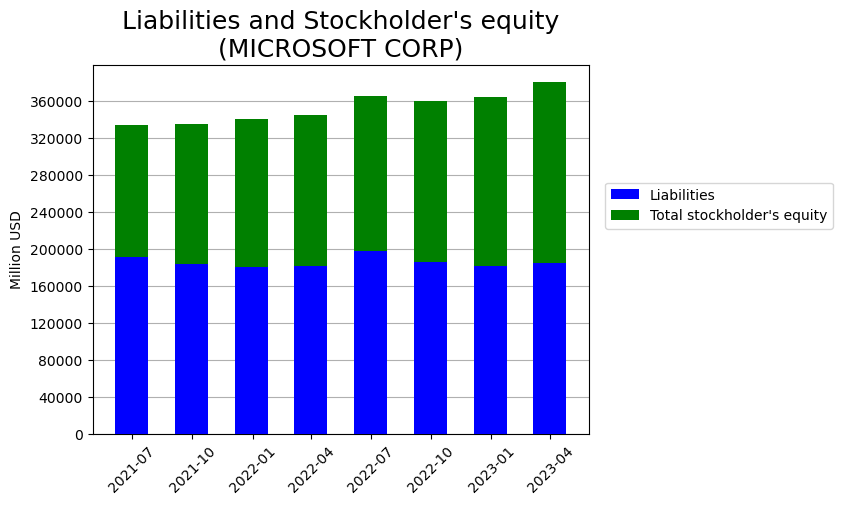

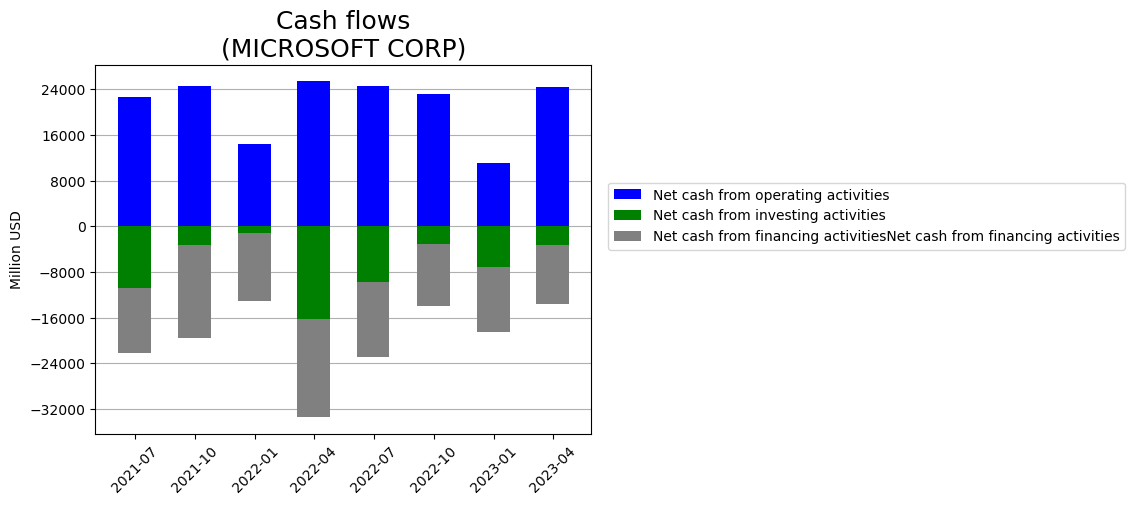

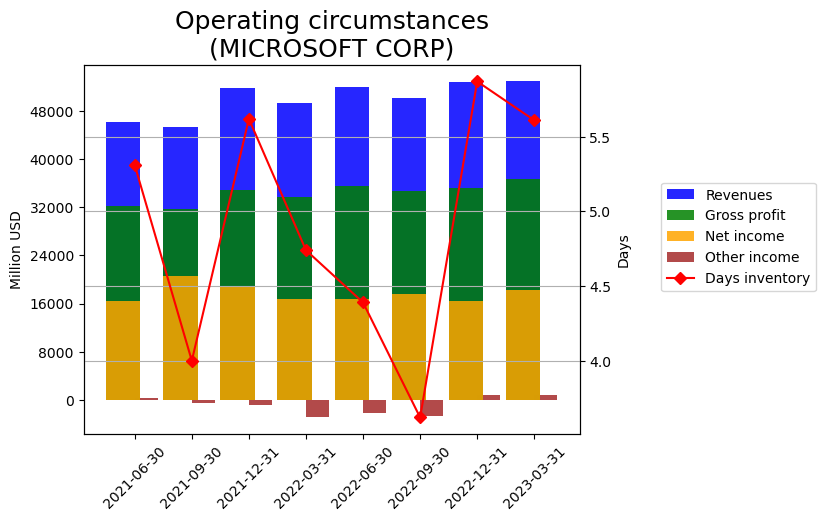

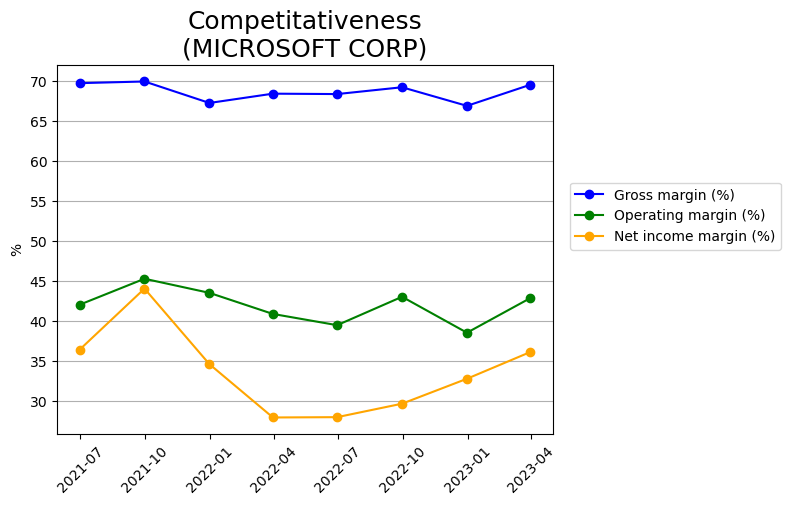

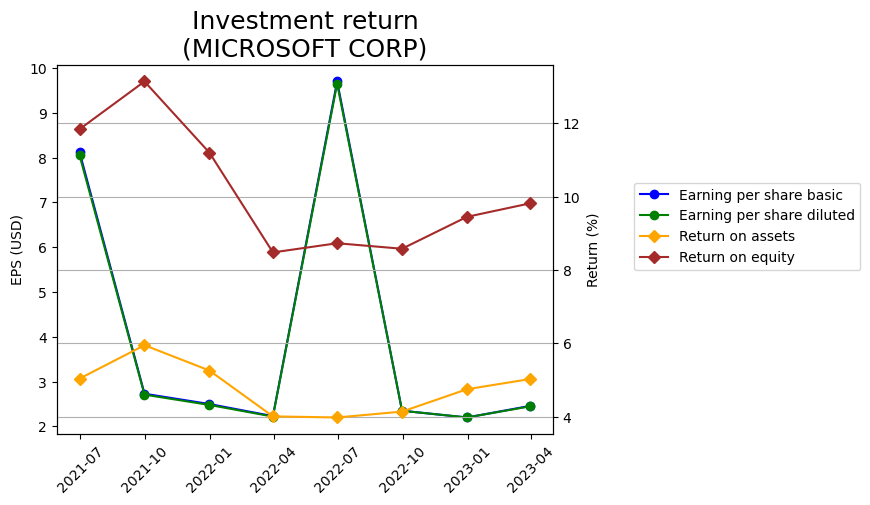

In [68]:
# Section 3: Plot 4 figures using seaborn package according to the above dataframe
def plot_data_non_financial(df, company_name):
    
    # Figure 1: Liabilities and Stockholder's equity stacked barchart (summation is assets)
    fig1 = plt.subplot(111)
    fig1.yaxis.set_major_locator(MaxNLocator(10))  # Max number of labels in y axis
    
    x = list(result.columns)  # x labels (quarter date)
    #x = [1,2,3,4,5,6,7,8]
    
    Liabilities = result.loc['Liabilities', :]
    Equity = result.loc["Total stockholder's equity", :]
    
    plt.bar(x, Liabilities, color='blue',label='Liabilities', width=50, zorder=3)
    plt.bar(x,Equity,color='green',label="Total stockholder's equity", width=50, bottom=Liabilities, zorder=3)
    plt.title("Liabilities and Stockholder's equity\n(" + company_name + ")", fontsize=18)
    plt.xticks(rotation=45)
    plt.ylabel('Million USD')
    plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
    plt.grid(axis='y')
    plt.show()
    
    
    
    
    
    # Figure 2: Cash flow stacked barchart
    fig2 = plt.subplot(111)
    fig2.yaxis.set_major_locator(MaxNLocator(10)) # Max number of labels in y axis
    operating =  result.loc['Net cash from operating activities', :]
      
    investing = result.loc['Net cash from investing activities', :]
    
    financing = result.loc['Net cash from financing activities', :]

    plt.bar(x, operating, color='blue', label='Net cash from operating activities', width=50, zorder=3)

    # Stack upward or downward depends on the sign of value. Downward for negative values
    # Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
    baseline = []
    

    
    # Setting baseline for stacking investing values
    for idx in range(len(df.columns)):
        if(investing[idx] < 0):
            if(operating[idx] < 0):
                baseline.append(operating[idx]) 
            else:
                baseline.append(0) 
        else:
            if(operating[idx] < 0):
                baseline.append(0) 
            else:
                baseline.append(operating[idx]) 


    plt.bar(x, investing, color='green',label='Net cash from investing activities', width=50, zorder=3, bottom=baseline)

    
    
    baseline2 = []
    for idx in range(len(df.columns)):
        
        # Same sign of investing value and financing value (++ or --)
        if(investing[idx]*financing[idx] >= 0):
            baseline2.append(investing[idx])
        
        # Different sign of investing and financing value (+- or -+)
        else:
            
            # Same sign of investing value and operating value (++ or --)
            if(operating[idx]*investing[idx] >= 0):
                baseline2.append(0)
                #print('second')
                
            # Different sign of investing and operating value (+- or -+)    
            else:
                baseline2.append(operating[idx])
                #print('third')
                #print(operating[idx]*investing[idx])

    plt.bar(x, financing, color='gray', label='Net cash from financing activitiesNet cash from financing activities', width=50, zorder=3, bottom=baseline2)

    plt.title('Cash flows\n(' + company_name + ")", fontsize=18)
    plt.xticks(rotation=45)
    plt.ylabel('Million USD')
    plt.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left')
    plt.grid(axis='y')
    plt.show()
    
    
    
    # Figure 3: Operating circumstance
    fig3 = plt.subplot(111)
    fig3.yaxis.set_major_locator(MaxNLocator(10)) # Max number of labels in y axis
    plt.xticks(rotation=45)  # Need to place this setting before plotting or interpreter will confuse
    
    revenue = result.loc['Revenue', :]
    gross_profit = result.loc['Gross profit', :]
    net_income = result.loc['Net income', :]
    other_income = result.loc['Comprehensive income net of tax', :] - result.loc['Net income', :]
    days_inventory = result.loc['Days Inventory (days)', :]
    
    x_temp = np.arange(len(x))
    
    br1 = plt.bar(x_temp - 0.2, revenue, color='blue',label='Revenues', width=0.6, zorder=2, alpha = 0.85)
    br2 = plt.bar(x_temp - 0.2, gross_profit, color='green',label='Gross profit', width=0.6, zorder=2, alpha = 0.85)
    br3 = plt.bar(x_temp - 0.2, net_income, color='orange',label='Net income', width=0.6, zorder=3, alpha = 0.85)
    br4 = plt.bar(x_temp + 0.2, other_income, color='brown',label='Other income', width=0.4, zorder=1, alpha = 0.85)
    
    
    
    # Double y axes
    fig3_1 = fig3.twinx()
    ln1 = fig3_1.plot(x_temp, days_inventory, color='red', marker='D',label='Days inventory')
    
    plt.xticks(x_temp, x)
    
    plt.title("Operating circumstances\n(" + company_name + ")", fontsize=18)
    
    #plt.ylabel('Million USD')
    
    
    fig3.set_ylabel('Million USD')
    fig3_1.set_ylabel('Days')
    
    #print(type(br1))
    
    #brs_lns = br1 + br2 + br3 + br4 + ln1
    #brs_lns = list(br1) + ln1
    brs_lns = [br1, br2, br3, br4] + ln1
    #labels = [bl.get_label() for bl in brs_lns]
    plt.legend(handles = brs_lns, bbox_to_anchor=(1.15,0.7), loc='upper left')
    #plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
    
    plt.grid(axis='y')
    
    plt.show()
    
    
    
    # Figure 4: Competitiveness
    gross_margin = result.loc['Gross margin (%)', :]
    operating_margin = result.loc['Operating margin (%)', :]
    net_income_margin = result.loc['Net income margin (%)', :]
    
    
    fig4 = plt.subplot(111)
    fig4.yaxis.set_major_locator(MaxNLocator(10))

    fig4.plot(x,gross_margin,color='blue', marker='o',label='Gross margin (%)')
    fig4.plot(x,operating_margin,color='green', marker='o',label='Operating margin (%)')
    fig4.plot(x,net_income_margin,color='orange', marker='o',label='Net income margin (%)')

    fig4.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
    fig4.grid(axis='y')
    plt.xticks(rotation=45)
    plt.title('Competitativeness\n(' + company_name + ')', fontsize=18)
    fig4.set_ylabel('%')
    plt.show()
    
    
    
    
    # Figure 5: Investment return
    fig5 = plt.subplot(111)
    fig5.yaxis.set_major_locator(MaxNLocator(10))
    plt.xticks(rotation=45)
    
    earning_per_share_basic = result.loc['Earning per share basic', :]
    earning_per_share_diluted = result.loc['Earning per share diluted', :]
    return_on_assets = result.loc['Return on assets (%)', :]
    return_on_equity = result.loc['Return on equity (%)', :]
    
    ln1 = plt.plot(x,earning_per_share_basic,color='blue', marker='o',label='Earning per share basic')
    ln2 = plt.plot(x,earning_per_share_diluted,color='green', marker='o',label='Earning per share diluted')
      
    
    # Double y axes
    fig5_1 = fig5.twinx()
    ln3 = fig5_1.plot(x, return_on_assets, color='orange', marker='D',label='Return on assets')
    ln4 = fig5_1.plot(x, return_on_equity, color='brown', marker='D',label='Return on equity')
    
    
    plt.title("Investment return\n(" + company_name + ")", fontsize=18)
    

    
    
    fig5.set_ylabel('EPS (USD)')
    fig5_1.set_ylabel('Return (%)')
    
    #print(type(br1))
    
    #brs_lns = br1 + br2 + br3 + br4 + ln1
    #brs_lns = list(br1) + ln1
    lns = ln1 + ln2 + ln3 + ln4
    #labels = [bl.get_label() for bl in brs_lns]
    plt.legend(handles = lns, bbox_to_anchor=(1.15,0.7), loc='upper left')
    #plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
    
    plt.grid(axis='y')
    
    plt.show()
    
    
plot_data_non_financial(result, company_name)

## Some test below

In [20]:
res = reports[0].find("ix:nonnumeric", {"id" : re.compile(r"fact-identifier-23")})
print(type(res))
print(res)

<class 'bs4.element.Tag'>
<ix:nonnumeric contextref="i02c0f3e92d75432fbe3c6a24022bf7b0_D20200927-20210327" continued-taxonomy="false" data-original-id="id3VybDovL2RvY3MudjEvZG9jOmRhZDhkZWU5YWJlYTQ1NDM4YTBlMDI0ZmZiODE1ZDFhL3NlYzpkYWQ4ZGVlOWFiZWE0NTQzOGEwZTAyNGZmYjgxNWQxYV8xL2ZyYWc6NDJhYzk4NTk4NDNhNDY1YjgwOGU5ZDQ1MTliZGFiZDUvdGV4dHJlZ2lvbjo0MmFjOTg1OTg0M2E0NjViODA4ZTlkNDUxOWJkYWJkNV8yMTQ1_b4ea6b9e-486e-4c6c-8b88-765989412774" enabled-taxonomy="true" highlight-taxonomy="false" hover-taxonomy="false" id="fact-identifier-23" inside-table="false" isadditionalitemsonly="false" isamountsonly="false" iscalculationsonly="false" iscustomonly="false" isnegativesonly="false" isstandardonly="true" istextonly="true" name="dei:DocumentType" onclick="Taxonomies.clickEvent(event, this)" onkeyup="Taxonomies.clickEvent(event, this)" onmouseenter="Taxonomies.enterElement(event, this);" onmouseleave="Taxonomies.leaveElement(event, this);" selected-taxonomy="false" tabindex="18">10-Q</ix:nonnumeric>


In [61]:
other_income

NameError: name 'other_income' is not defined

In [26]:
from dateutil import parser 
time = parser.parse("20230331")
print(type(time))

time2 = parser.parse("20230331")
print(time2)

<class 'datetime.datetime'>
2023-03-31 00:00:00


In [12]:
# Python's switch-case pattern. No need to break.

x = 11
match x:
    case 1:
        print("Case 1")
    case 2:
        print("Case 2")
    case 10:
        print("Case 3")
    case _:
        print("Else")

Else
